In [328]:
# Dependencies:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

# Find list of unique cities in text files downloaded from NOAA:
path = "CRNH0203-201801010550"
file_array=[]
directory = os.path.join("c:",path)
for root,dirs,files in os.walk(directory):
    file_array.append(files[:])
city_list=[]    

unique_cities = set(x for l in file_array for x in l) 
for l in unique_cities:
    l = l[14:]     
    city_list.append(l)
city_list=set(city_list)

# Clean city list nulls:
city_list.remove("")

# Perform queries and calculations on text files downloaded from NOAA:
city_list=list(city_list)

results =[]
# Hand generated USDA zone dict:
usda={"1A":range(-60,-55),"1B":range(-55,-50),"2A":range(-50,-45),"2B":range(-45,-40),"3A":range(-40,-35),"3B":range(-35,-30),\
                      "4A":range(-30,-25),"4B":range(-25,-20),"5A":range(-20,-15),"5B":range(-15,-10),"6A":range(-10,-5),"6B":range(-5,0),\
                      "7A":range(0,5),"7B":range(5,10),"8A":range(10,15),"8B":range(15,20),"9A":range(20,25),"9B":range(25,30),"10A":range(30,35),\
                      "10B":range(35,40),"11A":range(40,45),"11B":range(45,50),"12A":range(50,55),"12B":range(55,60),"13A":range(60,65),"13B":range(65,70)}

usda_actual =''
for city in city_list:
    for direct in paths:
        directory = os.path.join("c:",direct)
        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(city):
                    data = os.path.join(directory,file)
                    test_file_df = pd.read_table(data,header=None, delim_whitespace = True )
                    header_str = "WBANNO UTC_DATE UTC_TIME LST_DATE LST_TIME CRX_VN LONGITUDE LATITUDE T_CALC T_HR_AVG T_MAX T_MIN P_CALC SOLARAD SOLARAD_FLAG SOLARAD_MAX SOLARAD_MAX_FLAG SOLARAD_MIN SOLARAD_MIN_FLAG SUR_TEMP_TYPE SUR_TEMP SUR_TEMP_FLAG SUR_TEMP_MAX SUR_TEMP_MAX_FLAG SUR_TEMP_MIN SUR_TEMP_MIN_FLAG RH_HR_AVG RH_HR_AVG_FLAG SOIL_MOISTURE_5 SOIL_MOISTURE_10 SOIL_MOISTURE_20 SOIL_MOISTURE_50 SOIL_MOISTURE_100 SOIL_TEMP_5 SOIL_TEMP_10 SOIL_TEMP_20 SOIL_TEMP_50 SOIL_TEMP_100"
                    headers =header_str.split(" ")
                    test_file_df.columns =headers
                    # Remove bad data points: 
                    test_file_df=test_file_df[test_file_df['T_MIN'] > -100]
                    # Convert to temps to Fahrenheit:
                    test_file_df['T_MIN_F']=test_file_df['T_MIN']*9/5 +32

                     # Tag rows based on the 32F threshold:
                    test_file_df['tag'] = test_file_df["T_MIN_F"] < 32

                    # First row is a True preceded by a False:
                    fst = test_file_df.index[test_file_df['tag'] & ~ test_file_df['tag'].shift(1).fillna(False)]

                    # Last row is a True followed by a False:
                    lst = test_file_df.index[test_file_df['tag'] & ~ test_file_df['tag'].shift(-1).fillna(False)]

                    # Filter those which are adequately (i.e. 3 data points) apart:
                    pr = [(i, j) for i, j in zip(fst, lst) if j > i + 2]
                    
                    cum_freeze = 0
                    max_freeze = 0
                    min_temp_df = test_file_df.sort_values("T_MIN_F").head(1)
                    try:
                        min_temp=min_temp_df.loc[:,'T_MIN_F'].values[0]
                    except IndexError as e:
                        min_temp=="NA"
                    
                    # Find actual zone for year:
                    for key in usda:
                        if int(min_temp) in (usda[key]):
                            usda_actual=key

                    # Look for extended freezes:        
                    for dup in pr:
                        cum_freeze += (dup[1] - dup[0])
                        
                
                        if (dup[1] - dup[0]) > max_freeze:
                            max_freeze = (dup[1] - dup[0])
                     
                    # Pack results in a list:
                    result =[city[:-4],directory[24:28],cum_freeze,max_freeze,len(pr),int(min_temp),usda_actual]   
                    
                    # Append array for city and year:
                    results.append(result)
                         

# Remove Alaska data for simpler analysis:
no_alaska=[]
for result in results:
    if result[0][:2] != "AK":
        no_alaska.append(result)

# Downloaded list from USDA:
zone_df=pd.read_csv("zone_historical.csv")
freeze_df=pd.DataFrame(no_alaska,columns=['City','Year','Total_Freeze_Time','Max_Extended_Freeze_Time',"Number of Extended Freezes","Minimum_Temperature","USDA Zone Measured"])

# Remove limited 2018 data:
freeze_df=freeze_df[freeze_df['Year'] !='2018']

# Filter out stations with less than 10 years data:
summary= freeze_df['City'].value_counts()
summary_df=pd.DataFrame(summary).reset_index() 
summary_df.rename(columns={"index":"City","City":"Count"}, inplace = True)
filtered_df=summary_df[summary_df["Count"] > 9] 
report_df=pd.concat([filtered_df,zone_list_df],axis = 1)
report_df.rename(columns={0:"USDA Zone Historical"},inplace = True )


freeze_df        
 

,City,Year,Total_Freeze_Time,Max_Extended_Freeze_Time,Number of Extended Freezes,Minimum_Temperature,USDA Zone Measured
0,CO_Grand_Junction_9_W,2009,859,267,19,3,7A
1,CO_Grand_Junction_9_W,2010,1816,354,58,3,7A
2,CO_Grand_Junction_9_W,2011,1563,332,59,-3,6B
3,CO_Grand_Junction_9_W,2012,1255,307,61,6,7B
4,CO_Grand_Junction_9_W,2013,2080,303,58,0,7A
5,CO_Grand_Junction_9_W,2014,767,207,27,11,8A
6,AL_Selma_6_SSE,2007,100,13,12,21,9A
7,AL_Selma_6_SSE,2008,389,19,47,15,8B
8,AL_Selma_6_SSE,2009,344,16,35,15,8B
9,AL_Selma_6_SSE,2010,649,39,60,12,8A


In [447]:
# Prepare data for plots:
cities_8b=[]
cities_8b_long = list(merged_df['City'])

for city in cities_8b_long:
    cities_8b.append(city[:-4])
tot_fr_8b = list(merged_df['Total Freeze Time (mean)'])
tot_fr_sd_8b = list(merged_df['Total Freeze Time (stdev)'])
max_ext_fr_8b = list(merged_df["Max Extended Freeze Time (mean)"])
max_ext_fr_sd_8b = list(merged_df["Max Extended Freeze Time (stdev)"])
min_temp_8b = list(merged_df["Min Temperature (mean)"])
min_temp_sd_8b = list(merged_df["Min Temperature (stdev)"])
no_ext_fr_8b = list(merged_df['Number of Extended Freezes (mean)'])
no_ext_fr_sd_8b = list(merged_df['Number of Extended Freezes (stdev)'])
cities_8b

['AL_Fairhope_',
 'GA_Newton_1',
 'GA_Newton',
 'LA_Monroe_',
 'NV_Mercury_3',
 'OR_Corvallis_10',
 'SC_McClellanville_',
 'TX_Austin_3',
 'TX_Palestine_6',
 'TX_Panther_Junction',
 'WA_Quinault_']

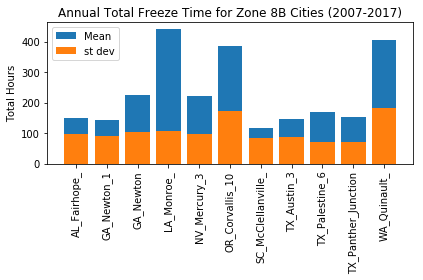

In [448]:


x=np.arange(len(cities_8b))

ax = plt.subplot()
ax.bar(x,tot_fr_8b,label='Mean')
ax.bar(x,tot_fr_sd_8b,label='st dev')
plt.xticks(x,cities_8b,rotation = 90)
plt.legend()

plt.title("Annual Total Freeze Time for Zone 8B Cities (2007-2017)")
plt.ylabel("Total Hours")
plt.tight_layout()
plt.savefig('8B_mean_tot_fr.png')
plt.show()

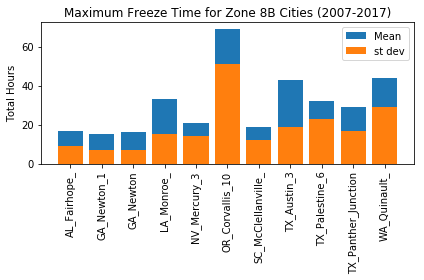

In [449]:
ax = plt.subplot()
ax.bar(x,max_ext_fr_8b,label='Mean')
ax.bar(x,max_ext_fr_sd_8b,label='st dev')
plt.xticks(x,cities_8b,rotation = 90)

plt.legend()
plt.title("Maximum Freeze Time for Zone 8B Cities (2007-2017)")
plt.ylabel("Total Hours") 
plt.tight_layout()
plt.savefig('8B_max_fr.png')
plt.show()

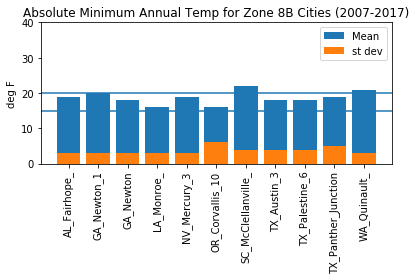

In [450]:
ax = plt.subplot()
ax.bar(x,min_temp_8b,label='Mean')
ax.bar(x,min_temp_sd_8b,label='st dev')
plt.xticks(x,cities_8b,rotation = 90)

plt.legend()
plt.title("Absolute Minimum Annual Temp for Zone 8B Cities (2007-2017)")
plt.ylabel("deg F")
plt.ylim(0,40)
plt.axhline(15)
plt.axhline(20)
plt.tight_layout()
plt.savefig('8B_abs_min.png')
plt.show()

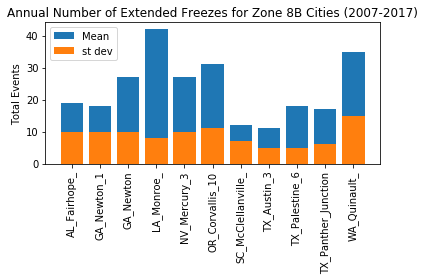

In [454]:
ax = plt.subplot()
ax.bar(x,no_ext_fr_8b,label='Mean')
ax.bar(x,no_ext_fr_sd_8b,label='st dev')
plt.xticks(x,cities_8b,rotation = 90)

plt.legend()
plt.title("Annual Number of Extended Freezes for Zone 8B Cities (2007-2017)")
plt.ylabel("Total Events")
plt.tight_layout()
plt.savefig('8B_ext_fr.png')
plt.show()

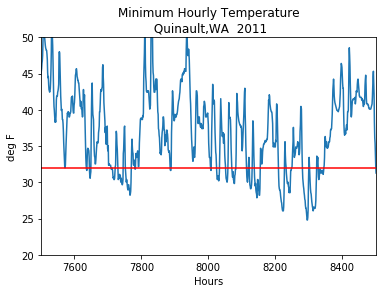

In [378]:
# Generate snapshot for Quinault 2011:
path = 'CRNH0203-201801010550\2011'

file = "CRNH0203-2011-WA_Quinault_4_NE.txt"
atx_file_df = pd.read_table(file,header=None, delim_whitespace = True )


header_str = "WBANNO UTC_DATE UTC_TIME LST_DATE LST_TIME CRX_VN LONGITUDE LATITUDE T_CALC T_HR_AVG T_MAX T_MIN P_CALC SOLARAD SOLARAD_FLAG SOLARAD_MAX SOLARAD_MAX_FLAG SOLARAD_MIN SOLARAD_MIN_FLAG SUR_TEMP_TYPE SUR_TEMP SUR_TEMP_FLAG SUR_TEMP_MAX SUR_TEMP_MAX_FLAG SUR_TEMP_MIN SUR_TEMP_MIN_FLAG RH_HR_AVG RH_HR_AVG_FLAG SOIL_MOISTURE_5 SOIL_MOISTURE_10 SOIL_MOISTURE_20 SOIL_MOISTURE_50 SOIL_MOISTURE_100 SOIL_TEMP_5 SOIL_TEMP_10 SOIL_TEMP_20 SOIL_TEMP_50 SOIL_TEMP_100"
headers =header_str.split(" ")
atx_file_df.columns =headers 
atx_file_df=atx_file_df[atx_file_df['T_MIN'] > -100]
atx_file_df['T_MIN_F']=atx_file_df['T_MIN']*9/5 +32

plt.plot(atx_file_df["T_MIN_F"])
plt.xlabel("Hours")
plt.ylabel("deg F")
plt.title("Minimum Hourly Temperature\n Quinault,WA  2011")
plt.axhline(y=32, xmin=0, xmax=9000, hold=None, color ='red')

plt.ylim(20,50)
plt.xlim(7500,8500)
plt.savefig("qwa_2011_min.png")
plt.show()

In [455]:
stat_decode_df = pd.read_csv('metadatasummary.csv',header=1)
stat_decode_df.dropna(axis = 0, how ='any', inplace=True)
stat_decode_df.drop_duplicates(inplace=True)
stat_decode_df.drop(stat_decode_df.index[1], inplace=True)


stat_decode_df

,StationId,Station,Date,Name,WBAN Number
0,1007,AK Barrow 4 ENE,20020810,NOAA (CMDL Observatory),27516
4,1798,AK Cordova 14 ESE,20170505,"Eyak Corporation, Cordova",96405
7,1793,AK Deadhorse 3 S,20140520,"AK Department of Natural Resources, Haul Road)",26565
10,1794,AK Denali 27 N,20150312,"NPS, Denali National Park (Wonder Lake Campgro...",96408
13,1008,AK Fairbanks 11 NE,20020809,NOAA / NESDIS (FCDAS),26494
20,1780,AK Gustavus 2 NE,20110817,"The Nature Conservancy, Gustavus Forelands Pre...",25380
23,1791,AK Ivotuk 1 NNE,20140519,"Arctic Slope Regional Corporation, Ivotuk Airs...",26564
26,1753,AK Kenai 29 ENE,20100817,Kenai National Wildlife Refuge (Kenai Moose Re...,26563
41,1754,AK Red Dog Mine 3 SSW,20100817,NANA Regional Corp Red Dog Mine,26655
44,1792,AK Ruby 44 ESE,20140519,"FWS, Nowitna National Wildlife Refuge (Lake Site)",96406
